# Bayesian A/B Testing

**Notebook by Carlos Santillán**
**Based on Vatsal's article in TowardsDataScience**

*This notebook has the purpose of serving me as a reference guide*

**April 2022**

There are many applications of A/B testing across various industries. From trying to identify optimal market groups to target to medical drug testing, it has various applications and allows businesses to make decisions based on the results. There are two common ways to approach A/B testing, the frequentist approach and the bayesian approach, both stepping from the foundations of hypothesis testing. 

## Bayesian Approach

The Bayesian approach stems from one main rule, that everything is a random variable. For example, if given some dataset and you were asked to find the mean and variance of the data, your output would simply be a numerical value mapped to the mean and a numerical value mapped to the variance. However, in the bayesian approach, you’re no longer looking for a number but a distribution.

When trying to identify the mean, you can see the difference of approaches below:

- **Frequentist:** $\hat{\mu}$

- **Bayesian:** $P(\hat{\mu}\; |\; data)$

### Bayesian Machine Learning

If you think about this from a machine learning perspective, then you can see that A/B testing is intuitively very similar to reinforcement learning. Reinforcement learning refers to allowing agents to take actions in an environment in order to maximize the notion of a reward. 

A/B testing can be viewed as a set of randomized experiments with randomly partitioned users to maximize some reward.

For example, if we were to model something like the click through rate of two buttons on our website with an A/B test, different layouts with different buttons can be defined as an action and increased click through rates can act as a reward. We want to pick a layout which will maximize the click through rate.

## Bayesian A/B Testing

Given some data, the bayesian procedure can be outlined with the following steps:

1. Identify out prior distribution (gaussian, poisson, beta, etc.), this expresses our initial understanding of a parameter (ῦ for example) prior to seeing any data

2. Choose a statistical model (Markov chains, bayesian bandits, etc.) which reflects our beliefs about x given $\hat{u}$

3. After observing some data, update our beliefs and calculate the posterior distribution $p(\hat{u} | x)$. The posterior distribution is a probability distribution which portrays your updated beliefs about your parameter after observing the data.



As you can imagine, the larger the number of observations (N), the better the approximation of your posterior distribution. However, if your number of observations is too large, you’re losing a lot of impressions which could generate revenue for your website. 

For example, if you were running an A/B test for your website to identify which (of two) landing pages yields a very high click through rate, then the more samples you do, the more people you’re exposing to a landing page which would decrease the clicks the number of clicks you would have potentially gotten. **Thus, having a sample size which is not too large and not too small is ideal**.

### Explore-Exploit Dilemma

In reinforcement learning, when an agent gathers information through assessing the scenario which may lead to a positive outcome is known as exploration. After exploration, one learns the optimal decisions with the highest possible outcome given the current known information is called exploitation. It’s best to balance exploration, and exploitation.

## Problem Statement

Suppose you want to test two different positions for creating users on your platform. You have position 1 which is located on the top left corner of your website whereas position 2 is located on the top right corner. The only difference between the two landing pages is the the sign up button is in two different locations, everything else is the same and our experiment is iid

## Bayesian Bandits / Thompson Sampling

Before we explore the bayesian bandits algorithm, we need to do a bit of review on bayes theorem and the beta distribution:

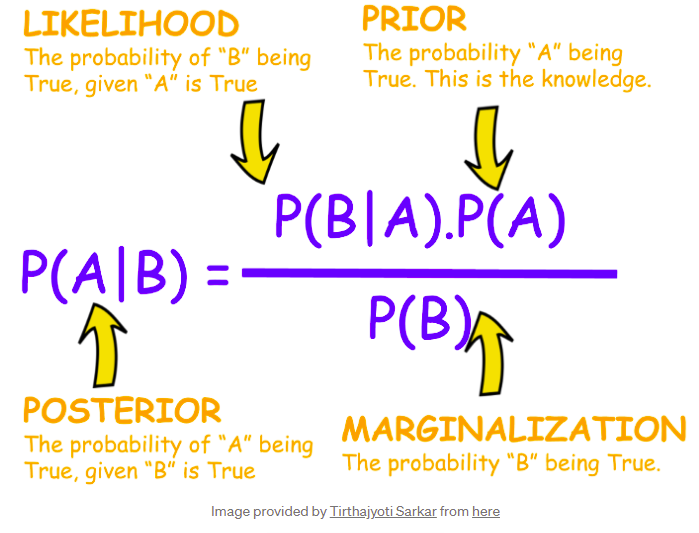

So, essentially: Posterior $\sim$ likelyhood * prior

### Beta Distribution

This is a continuous probability distribution which is bounded by the interval $[0, 1]$ and is dependent on two parameters α and β. Both α and β must be positive. Without going into the arithmetics, the PDF of the beta distribution can be modelled by the following equation:

$$f(x; \alpha,\beta)=\frac{x^{\alpha -1}(1-x)^{\beta -1}}{B(\alpha,\beta)}$$

Now we can explore the bayesian bandits / Thompson sampling algorithm. For the purposes of this experiment, let’s assume we know the click rate probabilities of each of both position 1 and position 2. 

Of course, in real world examples, this won’t happen but for the purposes of evaluating how well our algorithm will perform in this scenario, let’s say $p(pos1) = 0.1$ and $p(pos2) = 0.55$

Since we don’t have any existing observations, we can’t have any prior beliefs. To model our prior probabilities, we can use the beta distribution for α = 1 and β=1. This would be the uniform distribution over the domain of $[0,1]$.

**We choose the uniform distribution because we have no clue of what the result may be, thus we give equal probability to every possible value**. Note, for industry scenarios, if you have prior knowledge available then you should use that prior knowledge in your implementation.

For this method, the posterior in one step becomes the prior in the following step, our posterior and prior can both be modeled through beta.

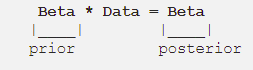

## Implementation

Note, that your implementation might have slightly varying results due to random sampling of the distribution.

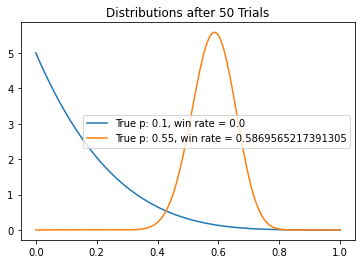

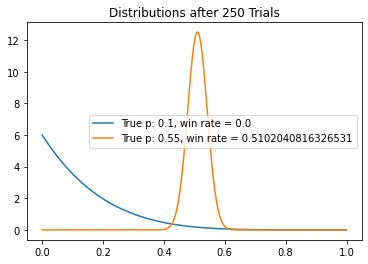

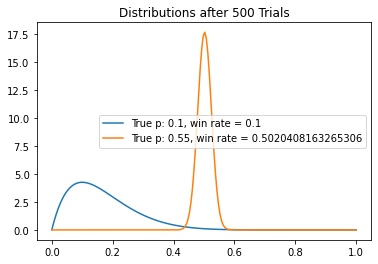

total reward earned: 539.0
overall win rate: 0.539
num times selected each bandit: [11, 989]


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import beta

# constants
true_proba = {'L':0.1,'R':0.55}
num_trials = 1000
trial_list = [50, 250, 500]

class BayesianBandit(object):
    def __init__(self, p, alpha = 1, beta = 1, N = 0):
        '''
        params:
            p (Float) : probability bounded between 0 and 1
            alpha (Float) : alpha of the beta distribution, default of 1
            beta (Float) : beta of the beta distribution, default of 1
            N (Integer) : tracks the number of trials, default of 0
        '''
        self.p = p
        self.alpha = alpha
        self.beta = beta
        self.N = N

    def simulate_action(self):
        '''
        This function will simulate the real world of users clicking or different versions of the website.
        '''
        return np.random.random() < self.p

    def sample(self):
        '''
        This function draws a sample from the beta distribution
        '''
        return np.random.beta(self.alpha, self.beta)

    def update(self, x):
        '''
        This function will update the alpha, beta and N for every iteration
        '''
        self.alpha += x
        self.beta += 1 - x
        self.N += 1

def plot(bandits, trial):
    '''
    This function will help visualize the distributions associated to each version
    of the website. It helps in compraison of which version is better.
    
    params:
        bandits (Object) : defined by the BayesianBandit class
        trial (Integer) : number of trials
    '''
    x = np.linspace(0, 1, 200)
    for b in bandits:
        true_prob = b.p
        win_rate = (b.alpha - 1) / b.N
        y = beta.pdf(x, b.alpha, b.beta)
        plt.plot(x, y, label="True p: {}, win rate = {}".format(true_prob, win_rate))
    plt.title("Distributions after {} Trials".format(trial))
    plt.legend()
    plt.show()
    
def experiment():
    bandits = [BayesianBandit(p) for p in list(true_proba.values())]
    
    rewards = np.zeros(num_trials)
    
    for i in range(num_trials):
        # Thompson sampling
        j = np.argmax([b.sample() for b in bandits])

        if i in trial_list:
            plot(bandits, i)

        x = bandits[j].simulate_action()

        # update rewards
        rewards[i] = x

        # update the distribution
        bandits[j].update(x)

    # print total reward
    print("total reward earned:", rewards.sum())
    print("overall win rate:", rewards.sum() / num_trials)
    print("num times selected each bandit:", [b.N for b in bandits])

if __name__ == '__main__':
    experiment()

As you can see the algorithm converges quickly to the optimal distribution. Based on the results of this experiment, it is evident that the position 2 outperforms position 1 and should be the location of the sign up button on your website.

## Concluding Remarks

The main difference between the frequentist and bayesian approach is that the bayesian thinks of parameters as random variables. The steps to conduct an A/B test the bayesian way is to identify your prior distribution, choose a statistical model and to calculate and update your posterior distribution. 

Generally the bayesian approach to A/B testing converges quicker than other traditional A/B tests. This implies that a smaller sample is necessary to make a conclusion.

In [2]:
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('DS2_Bayesian_AB_Testing.ipynb')

--2022-04-22 23:55:25--  https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1864 (1.8K) [text/plain]
Saving to: ‘colab_pdf.py’

colab_pdf.py        100%[===================>]   1.82K  --.-KB/s    in 0s      

2022-04-22 23:55:25 (23.3 MB/s) - ‘colab_pdf.py’ saved [1864/1864]



MessageError: ignored